In [2]:
import networkx as nx
from numpy.linalg import matrix_power
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [3]:
def isklburnable(g, k, l):
    '''
    g: graph with networkx form
    k: number of sources
    l: number of rounds
    '''
    
    ############################################ Step0: get information
    N = nx.number_of_nodes(g)
    g_copy = cp.deepcopy(g)
    
    ''' '''
    #tip1: uncomment to draw origin graph
    print("0刚开始： input graph")
    nx.draw(g, with_labels=True, font_weight='bold')
    plt.show()
    ''' '''
    ########################################### Step1: get L
    L_list, tellburnfromL = getL(g, N, l, k)
    
    print(tellburnfromL)
    if tellburnfromL == True:
        return np.array(L_list[0]), [x for x in g.nodes()], True
    
    ########################################### Step2: initial
    source = -1*np.ones(k) #burnding sequence
    bestsequence = [[], 0] #1st entry: burning sequence; 2nd: number of burned nodes by this bs
    
    R_dynamic = [cp.copy(L_list[0])]
    burned = []
    level_burned = [] 
    
    print("2.0 初始化前： ")
    print("source", source)
    print("R", R_dynamic)
    print("\n")
    everything = updateR(k, L_list, g, 0, burned, source, level_burned, R_dynamic)
    
    burned, source, level_burned, R_dynamic = everything[0], everything[1], everything[2], everything[3]
    #TODO：！！！！！！！！！！！！！！！！！！返回的burn少一层
    print("copyburned", burned)
    #New check
    if len(burned) == N:
        return source, burned, True 
    
    print("2.1 初始化后： ")
    print("source1", source)
    print("R1", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("\n")
    
    ########################################### Step3: loop   
    while len(R_dynamic) != 0:
        
        while len(R_dynamic[k - 1]) != 0:
            source[k - 1] = R_dynamic[k - 1][0] # pick 1st 
            R_dynamic[k-1].remove(R_dynamic[k - 1][0]) #remove 1st
        
            burned.append(source[k-1]) 
            B = burned
        
            #burned B for rest rounds
            for rest_rounds in range(l - k + 1): #l-k
                B = findB(B, g)
                if len(B) == N:
                    return source, B, True
            
            burned.remove(source[k-1])
            
            if bestsequence[1] < len(B):
                bestsequence[0] = source    
                 
        R_dynamic.remove(R_dynamic[k - 1])         
        #level_burned.remove(level_burned[k-1])
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, k-2, burned, source, level_burned, R_dynamic)   
        #(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    return bestsequence[0], burned, False
    


In [4]:
def getL(g, N, l, k):
    L_list = [[x for x in g.nodes()]]
    #L_list = [[x for x in g.nodes() if g.degree(x)<=1]]
    tellburnedfromL = False
    num_remove = 0
    
    gl = cp.deepcopy(g) #used for l
    initial = range(N) 
    for i in range(l - 1):
        leaves = updateL(initial, gl)
        #print(leaves)
        initial = cp.deepcopy(leaves)
        L_list.append(initial)
    L_list.reverse()
    
    #print("1st", L_list)
    
    #TODO: fix1 initial empty
    
    while(len(L_list[0]) == 0):
      L_list.remove(L_list[0])
      #the second could only be 0, 1 or 2
      tellburnedfromL = True
      num_remove = num_remove + 1
    if len(L_list[0]) == 1:
      tellburnedfromL = True
    
    print("1得到L")
    print(L_list)
    print("\n")
    
    return L_list, tellburnedfromL

def updateL(input, g):#S1 get all leaves
    temp = [x for x in g.nodes() if g.degree(x)<=1] 
    #TODO:fix 2 <= 1 single node with degree 0
    
  #S2.1 remove leaves from graph
    for i in range(len(temp)): 
      g.remove_node(temp[i])
  #S2.2 return all non-leaves 
    return [x for x in input if x not in temp]

In [5]:
def findB(burned, gg):
    '''
        input: 
        a) burned: list of burned nodes
        b) gg: total graph
        output:
        nodes_burned_till_this_round
    '''
    nodes_burned_till_this_round = cp.copy(burned)
    # find all bunred vertice's neignbors
    for this_node in burned:
        nb_of_source = nx.all_neighbors(gg, this_node)
            
        for x in nb_of_source:
            if x not in nodes_burned_till_this_round: # keep unique
                nodes_burned_till_this_round.append(x)
    
    return nodes_burned_till_this_round #返回B set

In [6]:
def updateR(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    # 0 judge and recursion
      
    print("开始， 初始值是")
    print("在第几层：", num)
    print("source", source)
    print("R", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("此时R长度是",len(R_dynamic[num]))
    
    if len(R_dynamic[num]) == 0: #this row does not exist
        print("进入向上走")
        if num == 0:
            print("向上最终情况")
            R_dynamic.remove(R_dynamic[num])
            return burned, source, level_burned, R_dynamic
            #或者直接停/return best
            
        else:
        # Walk up
            print("向上的循环")
            R_dynamic.remove(R_dynamic[num])
            level_burned.remove(level_burned[num - 1])
            #upburned will replace burned
            upburned = []
            for i in level_burned:
                upburned = upburned + i
            
            print("向上走")
            print("R", R_dynamic)
            print("burned", upburned)
            print("level_burned", level_burned)
            print("结束")
            print("\n")
            
            updateR(k, L_list, g, num - 1, upburned, source, level_burned, R_dynamic)
  
        
    # 1. pick burn and remove 
    source[num] = R_dynamic[num][0]
    R_dynamic[num].remove(R_dynamic[num][0])
    old_burned = cp.copy(burned)
    burned.append(source[num])
    if num != 0:
        level_burned[num - 1].append(source[num])
    
    print("更新值是")
    print("1 source", source)
    print("2 R should remove", R_dynamic)
    print("3 burned", burned)
    print("5 level_burned", level_burned)
    # 2. update R
    # 2.1 get all burned nodes(B) in this round
    B = findB(burned, g)

        
    # PS: 也可以让findB只返回新burn的vertices
    # 2.2 burn
    if len(level_burned) == 0:
        level_burned.append(B)
    else:
        level_burned.append([node for node in B if node not in old_burned])
    burned = cp.copy(B) #update burn
    
    '''  '''     
    print("4 更新的burned", burned)
    print("5 level_burned", level_burned)
    ''' '''
    # 2.2 get L/B and update to the total R
    temp = [node for node in L_list[num + 1] if node not in B]
    print("处理前的R", temp)
    # deal with empty R
    if len(temp) == 0:
        print("inside empty check")
        print("端点两头",num + 2, len(L_list))
        if num + 2 == len(L_list): 
            print("我return的值")
            print("4 更新的burned", burned)

            return burned, source, level_burned, R_dynamic
        for inner_num in range(num + 2, len(L_list)): #choose L - 1
            temp = [node for node in L_list[inner_num] if node not in B]
            if len(temp) != 0:
                break
            print("num ", inner_num)
            if inner_num == len(L_list) - 1:
                return burned, source, level_burned, R_dynamic
          
    R_dynamic.append(temp)
        
    print("6 R should add", R_dynamic)
    print("for ", num, "th round")
    show2(g, burned)
    # 3. Walk down: if have not reach the k-1 level， to next level(0, 1, ..., k-2, k-1)
    if num < k - 2: #TODO: deal with new change of L_list (and num < len(L_list) - 2)
        print("结束向下走\n")
        updateR(k, L_list, g, num + 1, burned, source, level_burned, R_dynamic)
            
    return burned, source, level_burned, R_dynamic

In [7]:
# G: NetworkX graph
# burnt: a list of original labeled nodes that get burnt [3,1,2] in the above example (看上面的上面的图)
# sources: a list of origin labeled sources [3,2]
# labels: a dictionary with key: original labeled node, value: in what round it burnt {2:'1',3:'2'}
def show(G, sources, burnt):
    labels = {}
    for i in range(len(sources)):
        if sources[i] != -1:
            labels[sources[i]] = i + 1
    print(labels, len(labels))
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos,arrows=None, with_labels=False)    # plot original graph
    nx.draw_networkx(G, pos=pos,nodelist = burnt,arrows=None, node_color="tab:green",with_labels=False) # represent burnt nd
    if (len(labels) != 0) :
        nx.draw_networkx(G, pos=pos,nodelist = sources,arrows=None, node_color="tab:red",with_labels=False) # represnet sources
        description = nx.draw_networkx_labels(G,pos=pos,labels=labels)    # plot sources' 


In [8]:
def show2(G, burnt):
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos,arrows=None, with_labels=False)    # plot original graph
    nx.draw_networkx(G, pos=pos,nodelist = burnt,arrows=None, node_color="tab:green",with_labels=False) # represent burnt nd' 

In [9]:
g1 = nx.random_tree(9)
g2 = nx.random_tree(9)
g3 = nx.random_tree(9)
g4 = nx.random_tree(9)

0刚开始： input graph


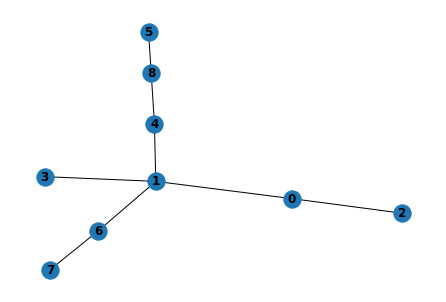

1得到L
[[1, 4], [0, 1, 4, 6, 8], [0, 1, 2, 3, 4, 5, 6, 7, 8]]


False
2.0 初始化前： 
source [-1. -1. -1.]
R [[1, 4]]


开始， 初始值是
在第几层： 0
source [-1. -1. -1.]
R [[1, 4]]
burned []
level_burned []
此时R长度是 2
更新值是
1 source [ 1. -1. -1.]
2 R should remove [[4]]
3 burned [1.0]
5 level_burned []
4 更新的burned [1.0, 0, 3, 6, 4]
5 level_burned [[1.0, 0, 3, 6, 4]]
处理前的R [8]
6 R should add [[4], [8]]
for  0 th round
结束向下走

开始， 初始值是
在第几层： 1
source [ 1. -1. -1.]
R [[4], [8]]
burned [1.0, 0, 3, 6, 4]
level_burned [[1.0, 0, 3, 6, 4]]
此时R长度是 1
更新值是
1 source [ 1.  8. -1.]
2 R should remove [[4], []]
3 burned [1.0, 0, 3, 6, 4, 8.0]
5 level_burned [[1.0, 0, 3, 6, 4, 8.0]]
4 更新的burned [1.0, 0, 3, 6, 4, 8.0, 2, 7, 5]
5 level_burned [[1.0, 0, 3, 6, 4, 8.0], [8.0, 2, 7, 5]]
处理前的R []
inside empty check
端点两头 3 3
我return的值
4 更新的burned [1.0, 0, 3, 6, 4, 8.0, 2, 7, 5]
copyburned [1.0, 0, 3, 6, 4, 8.0]
2.1 初始化后： 
source1 [ 1.  8. -1.]
R1 [[4], []]
burned [1.0, 0, 3, 6, 4, 8.0]
level_burned [[1.0, 0, 3, 6, 4, 8.0], [8.0, 2, 

IndexError: list index out of range

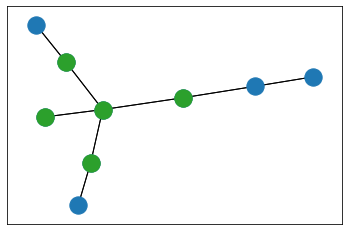

In [11]:

'''
ans3 = isklburnable(g3, 3, 3)
ans4 = isklburnable(g4, 3, 3)
ans2 = isklburnable(g2, 3, 3)
'''
gs1, gb1, gt1 = isklburnable(g3, 3, 3)
print(gt1)
#show(g1, gs1, gb1)

In [9]:
gg1 = nx.random_tree(16)
gg2 = nx.random_tree(16)
gg3 = nx.random_tree(16)
gg4 = nx.random_tree(16)

0刚开始： input graph


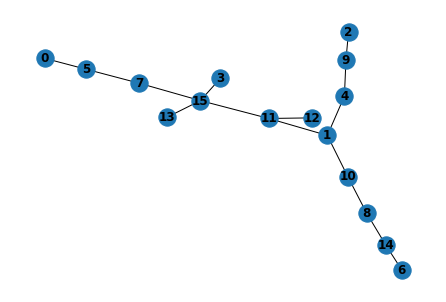

1得到L
[[1, 11], [1, 10, 11, 15], [1, 4, 7, 8, 10, 11, 15], [1, 4, 5, 7, 8, 9, 10, 11, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]


True
True


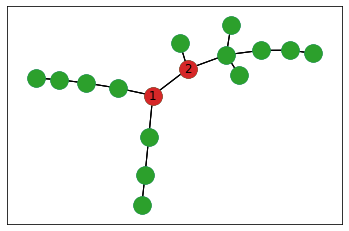

In [10]:
ggs1, ggb1, ggt1 = isklburnable(gg1, 4, 16)
print(ggt1)
show(gg1, ggs1, ggb1)


0刚开始： input graph


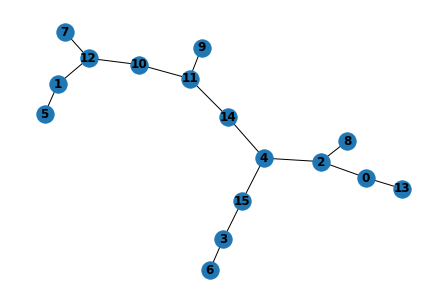

1得到L
[[11, 14], [4, 10, 11, 14], [2, 4, 10, 11, 12, 14, 15], [0, 1, 2, 3, 4, 10, 11, 12, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]


True
True


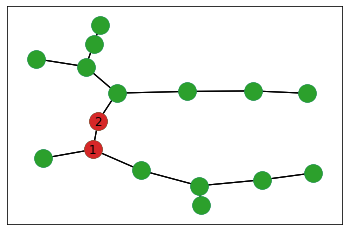

In [11]:
ggs2, ggb2, ggt2 = isklburnable(gg2, 4, 16)
print(ggt2)
show(gg2, ggs2, ggb2)

In [12]:
f1 = nx.random_tree(25)

0刚开始： input graph


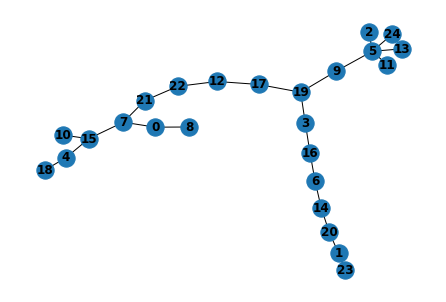

1得到L
[[3, 6, 12, 16, 17, 19, 21, 22], [3, 6, 7, 12, 14, 16, 17, 19, 21, 22], [3, 6, 7, 9, 12, 14, 15, 16, 17, 19, 20, 21, 22], [0, 1, 3, 4, 5, 6, 7, 9, 12, 14, 15, 16, 17, 19, 20, 21, 22], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]


False
2.0 初始化前： 
source [-1. -1. -1. -1.]
R [[3, 6, 12, 16, 17, 19, 21, 22]]


2.0+b go down
2.0+b go down
2.1 初始化后： 
source1 [ 3.  6.  7. -1.]
R1 [[6, 12, 16, 17, 19, 21, 22], [7, 12, 14, 17, 21, 22], [12, 15, 20, 21, 22], [1, 4, 22]]
burned [3.0, 16, 19, 6.0]
level_burned [[3.0, 16, 19, 6.0], [6.0, 17, 9, 14], [7.0, 12, 5, 20, 0, 15, 21]]


True


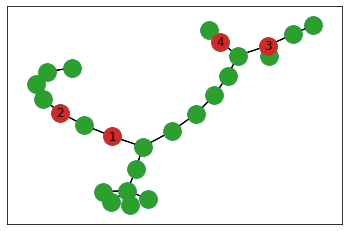

In [13]:
fs1, fb1, ft1 = isklburnable(f1, 4, 5)
print(ft1)
show(f1, fs1, fb1)

In [14]:
qi1 = nx.random_tree(49)

0刚开始： input graph


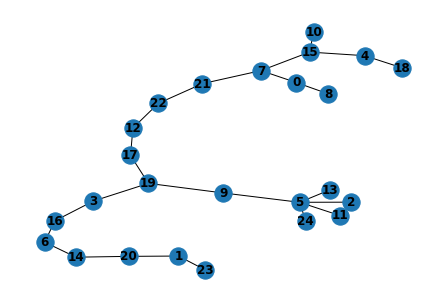

1得到L
[[3, 12, 17, 19], [3, 12, 16, 17, 19, 22], [3, 6, 12, 16, 17, 19, 21, 22], [3, 6, 7, 12, 14, 16, 17, 19, 21, 22], [3, 6, 7, 9, 12, 14, 15, 16, 17, 19, 20, 21, 22], [0, 1, 3, 4, 5, 6, 7, 9, 12, 14, 15, 16, 17, 19, 20, 21, 22], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]


False
2.0 初始化前： 
source [-1. -1. -1. -1.]
R [[3, 12, 17, 19]]


2.0+b go down
2.0+b go down
2.1 初始化后： 
source1 [ 3. 12. 21. -1.]
R1 [[12, 17, 19], [17, 22], [], [15, 20]]
burned [3.0, 16, 19, 12.0]
level_burned [[3.0, 16, 19, 12.0], [12.0, 6, 17, 9, 22], [21.0, 14, 5, 7]]


2.0+b go down
True


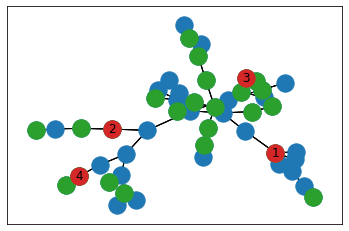

In [16]:
qis1, qib1, qit1 = isklburnable(f1, 4, 7)
print(qit1)
show(qi1, qis1, qib1)

In [17]:
ten1 = nx.random_tree(100)

0刚开始： input graph


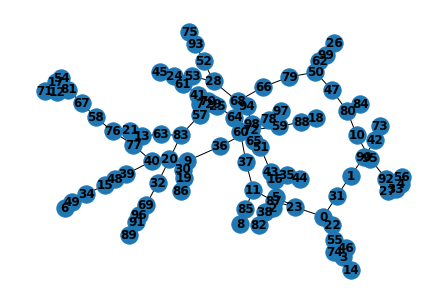

1得到L
[[9, 24, 25, 28, 36, 37, 40, 41, 53, 60, 61, 64, 68, 72], [9, 11, 24, 25, 28, 36, 37, 40, 41, 53, 60, 61, 64, 66, 68, 72, 77], [9, 11, 13, 24, 25, 28, 36, 37, 40, 41, 53, 60, 61, 64, 66, 68, 72, 77, 79, 87], [9, 11, 13, 23, 24, 25, 28, 36, 37, 40, 41, 50, 53, 60, 61, 63, 64, 66, 68, 72, 77, 79, 87], [0, 9, 11, 13, 23, 24, 25, 28, 36, 37, 40, 41, 47, 50, 53, 60, 61, 63, 64, 66, 68, 72, 76, 77, 79, 83, 87], [0, 5, 9, 11, 13, 20, 23, 24, 25, 28, 31, 36, 37, 39, 40, 41, 47, 50, 53, 58, 60, 61, 63, 64, 66, 68, 72, 76, 77, 79, 80, 83, 87], [0, 1, 5, 9, 10, 11, 13, 15, 20, 23, 24, 25, 28, 31, 32, 36, 37, 39, 40, 41, 43, 47, 50, 53, 58, 60, 61, 63, 64, 66, 67, 68, 72, 76, 77, 79, 80, 83, 87], [0, 1, 5, 9, 10, 11, 13, 15, 20, 23, 24, 25, 28, 31, 32, 34, 36, 37, 39, 40, 41, 43, 47, 50, 51, 52, 53, 55, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 72, 76, 77, 79, 80, 81, 83, 87, 90, 95], [0, 1, 3, 5, 9, 10, 11, 12, 13, 15, 19, 20, 23, 24, 25, 28, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47,

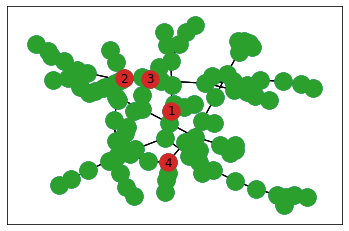

In [18]:
tsource, tret, yes = isklburnable(ten1, 4, 10)
print(qit1)
show(ten1, tsource, tret)